In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\rafae\AppData\Local\Temp\ipykernel_12212\3632437423.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Conhecendo um pouco dos dados

In [2]:
precificacao = pd.read_csv("../data/teste_indicium_precificacao.csv")

### Concatenando com dados de input, somente para os dados de input sofrerem o mesmo tratamento dos dados de treino e teste

In [3]:
data_set_original_linhas = precificacao.shape[0]

In [4]:
validacao = pd.DataFrame({'id': [2595],
 'nome': ['Skylit Midtown Castle'],
 'host_id': [2845],
 'host_name': ['Jennifer'],
 'bairro_group': ['Manhattan'],
 'bairro': ['Midtown'],
 'latitude': [40.75362],
 'longitude': [-73.98377],
 'room_type': ['Entire home/apt'],
 'price': [225],
 'minimo_noites': [1],
 'numero_de_reviews': [45],
 'ultima_review': ['2019-05-21'],
 'reviews_por_mes': [0.38],
 'calculado_host_listings_count': [2],
 'disponibilidade_365': [355]})

*1.Faça uma análise exploratória dos dados (EDA), demonstrando as principais características entre as variáveis e apresentando algumas hipóteses de negócio relacionadas. Seja criativo!*

In [5]:
import sweetviz as sv

# Prepare-se: EDA automática tende a demorar!
my_report = sv.analyze(precificacao, target_feat='price')
my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

z:\projetos\projeto-lighthouse-indicium\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Pelo sweetviz é possível fazer algumas análises inicias. Primeiro, colunas que não se repetem muito e tendem a ter valores categoricos únicos não são bons para o modelo, me refiro a colunas com id, nome, host_id... Elas criam um senso de aleatoriedade para o modelo. Possível ver algumas destribuições como a classe price que é uma variável contínua e tende a não ter um campo de variação muito grande.

*2.Responda também às seguintes perguntas:*

*a.Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?*

In [6]:
apartamento_com_minimo_1_review = precificacao[precificacao["numero_de_reviews"] >= 1]
apartamento_com_minimo_1_review.groupby("bairro_group").agg({"price": "mean"}).reset_index().sort_values(by="price", ascending=False).head(10)

,bairro_group,price
2,Manhattan,180.052489
1,Brooklyn,121.447039
3,Queens,95.762571
4,Staten Island,89.964968
0,Bronx,79.553653


In [7]:
apartamento_com_minimo_1_review.groupby("bairro_group").count().reset_index().sort_values(by="id", ascending=False).head(10)[["bairro_group", "bairro", "id"]].rename(columns={"id": "quantidade_de_ofertas_dos_5_maiores"})

,bairro_group,bairro,quantidade_de_ofertas_dos_5_maiores
2,Manhattan,16632,16632
1,Brooklyn,16446,16446
3,Queens,4574,4574
0,Bronx,876,876
4,Staten Island,314,314


In [8]:
apartamento_com_minimo_1_review.groupby("bairro_group").count().reset_index().sort_values(by="id", ascending=True).head(10)[["bairro_group", "bairro", "id"]].rename(columns={"id": "quantidade_de_ofertas_dos_5_maiores"})

,bairro_group,bairro,quantidade_de_ofertas_dos_5_maiores
4,Staten Island,314,314
0,Bronx,876,876
3,Queens,4574,4574
1,Brooklyn,16446,16446
2,Manhattan,16632,16632


Consideramos todos os apartamentos com 1+ review para responder essa perguntas, ou seja apartamentos que já foram usados por alguém da plataforma, não faria muito sentido pegar apartamento sem reviewers, pois o preço poderia estar como um outlier somente porque a pessoa oferecendo quis colocar aquele preço, mas não adianta de nada colocar um preço e o apartamento não ser alugado

Manhattan e brooklyn possuem um preço médio bastante alto o que é bom, mas eles estão bastante saturados, existem muitos apartamentos lá. já Staten Island e Bronx possuem um preço médio baixo quando comparado a Manhattan e Brooklyn e uma quantidade pequena de apartamentos disponíveis. Aqui depende da decisão de negócio, se fosse para alugar para executivos e pessoas relacionadas a trabalho, o investimento em bairros mais centrais (Manhattan e Brooklyn) possa ser que der certo. Mas se o intúito for para famílias e outros que procuram descanso e uma área mais isolada da cidade, o investimento em Staten Island e Bronx vale mais a pena por ter menos apartamentos disponíveis.

*b.O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?*

In [9]:
b = precificacao[['minimo_noites', 'disponibilidade_365','price']]
b.corr()

,minimo_noites,disponibilidade_365,price
minimo_noites,1.000000,0.144320,0.042799
disponibilidade_365,0.144320,1.000000,0.081833
price,0.042799,0.081833,1.000000


As correlações desses 2 atributos com o preço são bem baixas (perto de 0), por isso eles tendem a não afetar muito no valor do apartamento, mais para frentes haverá um estudo das correlações e como elas afetam a variável "target".

*c.Existe algum padrão no texto do nome do local para lugares de mais alto valor?*

In [10]:
c = precificacao[["nome","price"]].sort_values(by="price",ascending=False)
display(c.head(10))
display(c.tail(10))

,nome,price
9150,Furnished room in Astoria apartment,10000
29237,1-BR Lincoln Center,10000
17691,Luxury 1 bedroom apt. -stunning Manhattan views,10000
12341,"Quiet, Clean, Lit @ LES & Chinatown",9999
40432,2br - The Heart of NYC: Manhattans Lower East ...,9999
6529,Spanish Harlem Apt,9999
30267,Beautiful/Spacious 1 bed luxury flat-TriBeCa/Soho,8500
4376,Film Location,8000
29661,East 72nd Townhouse by (Hidden by Airbnb),7703
45665,Gem of east Flatbush,7500


,nome,price
25432,★Hostel Style Room | Ideal Traveling Buddies★,0
25777,Modern apartment in the heart of Williamsburg,0
26865,Best Coliving space ever! Shared room.,0
26840,Coliving in Brooklyn! Modern design / Shared room,0
25795,Cozy yet spacious private brownstone bedroom,0
26258,the best you can find,0
25633,"MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)",0
25793,Spacious comfortable master bedroom with nice ...,0
25794,Contemporary bedroom in brownstone with nice view,0
23160,"Huge Brooklyn Brownstone Living, Close to it all.",0


Nenhum padrão no texto, mas os mais caros tendem a descrever o apartamento, exemplo "Beautiful/Spacious 1 bed luxury flat-TriBeCa/Soho".

In [11]:
precificacao = pd.concat([precificacao, validacao])

## Conhecendo os dados

In [12]:
precificacao.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [13]:
precificacao.columns

Index(['id', 'nome', 'host_id', 'host_name', 'bairro_group', 'bairro',
       'latitude', 'longitude', 'room_type', 'price', 'minimo_noites',
       'numero_de_reviews', 'ultima_review', 'reviews_por_mes',
       'calculado_host_listings_count', 'disponibilidade_365'],
      dtype='object')

Dados nulos?

In [14]:
precificacao.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48895 entries, 0 to 0
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48895 non-null  int64  
 1   nome                           48879 non-null  object 
 2   host_id                        48895 non-null  int64  
 3   host_name                      48874 non-null  object 
 4   bairro_group                   48895 non-null  object 
 5   bairro                         48895 non-null  object 
 6   latitude                       48895 non-null  float64
 7   longitude                      48895 non-null  float64
 8   room_type                      48895 non-null  object 
 9   price                          48895 non-null  int64  
 10  minimo_noites                  48895 non-null  int64  
 11  numero_de_reviews              48895 non-null  int64  
 12  ultima_review                  38843 non-null  object 


COLOCAR SWEET VIZ AQUi

<Axes: >

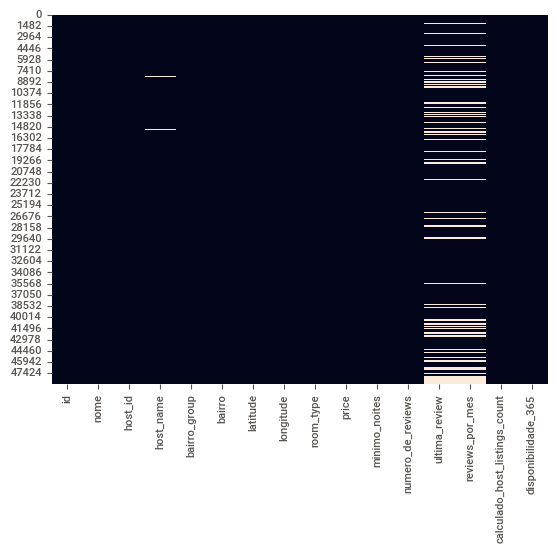

In [15]:
sns.heatmap(precificacao.isnull(), cbar=False)

Nulos poderia ser interpretado como 0 reviews?

In [16]:
len(precificacao[precificacao["ultima_review"] == 0])

0

In [17]:
len(precificacao[precificacao["reviews_por_mes"] == 0])

0

Justificado!

In [18]:
linhas, colunas = precificacao.shape
print(f"Planilha contém {linhas} linhas e {colunas} colunas")

Planilha contém 48895 linhas e 16 colunas


In [19]:
precificacao.describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728951,-73.952170,152.722242,7.029962,23.275202,1.373226,7.143900,112.781123
std,1.098311e+07,7.861097e+07,0.054529,0.046157,240.154392,20.510550,44.550644,1.680439,32.952527,131.621905
min,2.595000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983075,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723080,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Dados duplicados?

In [20]:
True in precificacao.duplicated().values

True

## Tratamento

Preenchendo NaN em reviews por mes para 0. A outra coluna ultima_review é melhor não ser preenchida por estar como object e seu real formato é datetime (modificação feita posteriormente).

In [21]:
precificacao['reviews_por_mes'] = precificacao['reviews_por_mes'].fillna(value=0)

<Axes: >

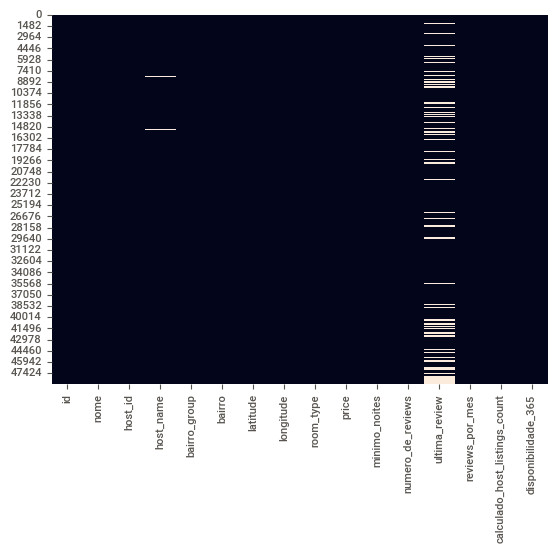

In [22]:
sns.heatmap(precificacao.isnull(), cbar=False)

Modificando última_review para datetime

In [23]:
precificacao["ultima_review"] = pd.to_datetime(precificacao["ultima_review"])
precificacao["ultima_review"].to_frame().dtypes

ultima_review    datetime64[ns]
dtype: object

In [24]:
precificacao_limpo = precificacao.copy()

COLUNAS CATEGORICAS DE STRING PARA DUMMIES

In [25]:
precificacao = pd.get_dummies(precificacao, columns=["bairro_group"], drop_first=False)
precificacao = pd.get_dummies(precificacao, columns=["bairro"], drop_first=False)
precificacao = pd.get_dummies(precificacao, columns=["room_type"], drop_first=True)


COLUNAS CATEGORICAS DE INTERIOS PARA CATEGORY

In [26]:
precificacao["host_id"] = precificacao["host_id"].astype("category")

Existem host names que se repetem?

In [27]:
len(precificacao["host_name"].unique())

11453

In [28]:
precificacao.shape

(48895, 241)

Sim, transformando host_name pra categorical

In [29]:
precificacao["host_name"] = precificacao["host_name"].astype("category")

Coluna última review para varias colunas (month and year)

In [30]:
precificacao["ultima_review_month"] = precificacao["ultima_review"].dt.month
precificacao["ultima_review_year"] = precificacao["ultima_review"].dt.year

Dropando nome da residência

In [31]:
precificacao.drop(columns=["nome","id","host_name", "ultima_review"], inplace=True)

In [32]:
precificacao

,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,bairro_group_Bronx,...,bairro_Willowbrook,bairro_Windsor Terrace,bairro_Woodhaven,bairro_Woodlawn,bairro_Woodrow,bairro_Woodside,room_type_Private room,room_type_Shared room,ultima_review_month,ultima_review_year
0,2845,40.75362,-73.98377,225,1,45,0.38,2,355,False,...,False,False,False,False,False,False,False,False,5.0,2019.0
1,4632,40.80902,-73.94190,150,3,0,0.00,1,365,False,...,False,False,False,False,False,False,True,False,NaN,NaN
2,4869,40.68514,-73.95976,89,1,270,4.64,1,194,False,...,False,False,False,False,False,False,False,False,7.0,2019.0
3,7192,40.79851,-73.94399,80,10,9,0.10,1,0,False,...,False,False,False,False,False,False,False,False,11.0,2018.0
4,7322,40.74767,-73.97500,200,3,74,0.59,1,129,False,...,False,False,False,False,False,False,False,False,6.0,2019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,6570630,40.70184,-73.93317,40,4,0,0.00,2,36,False,...,False,False,False,False,False,False,True,False,NaN,NaN
48891,23492952,40.81475,-73.94867,115,10,0,0.00,1,27,False,...,False,False,False,False,False,False,False,False,NaN,NaN
48892,30985759,40.75751,-73.99112,55,1,0,0.00,6,2,False,...,False,False,False,False,False,False,False,True,NaN,NaN
48893,68119814,40.76404,-73.98933,90,7,0,0.00,1,23,False,...,False,False,False,False,False,False,True,False,NaN,NaN


In [33]:
precificacao.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48895 entries, 0 to 0
Columns: 239 entries, host_id to ultima_review_year
dtypes: bool(228), category(1), float64(5), int64(5)
memory usage: 16.2 MB


Os dados são correlacionados? usar somento colunas com correlação relevante ou todas as anteriores?

In [34]:
precificacao_correlacoes = precificacao.corr()
precificacao_correlacoes_filtradas = precificacao_correlacoes[(precificacao_correlacoes["price"] > 0.05) | (precificacao_correlacoes["price"] < -0.05)]
# Adicionando latitude para complementar longitude
precificacao_correlacoes_filtradas = pd.concat([precificacao_correlacoes_filtradas, precificacao_correlacoes[precificacao_correlacoes.index == "latitude"]])
precificacao_correlacoes_filtradas

,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,bairro_group_Bronx,...,bairro_Willowbrook,bairro_Windsor Terrace,bairro_Woodhaven,bairro_Woodlawn,bairro_Woodrow,bairro_Woodside,room_type_Private room,room_type_Shared room,ultima_review_month,ultima_review_year
longitude,0.127059,0.084770,1.000000,-0.150023,-0.062745,0.059084,0.138517,-0.114711,0.082722,0.221315,...,-0.017637,-0.031750,0.086418,0.027375,-0.024112,0.074448,0.183636,0.029813,0.000798,0.101646
price,0.015303,0.033942,-0.150023,1.000000,0.042797,-0.047951,-0.050567,0.057471,0.081841,-0.041031,...,0.001813,-0.003245,-0.015127,-0.005786,0.010306,-0.019569,-0.240252,-0.053614,0.003661,-0.016629
reviews_por_mes,0.209781,-0.018779,0.138517,-0.050567,-0.124906,0.589399,1.000000,-0.047311,0.163737,0.036389,...,-0.000824,-0.003726,0.020216,0.012055,-0.003089,0.005718,0.030198,-0.001715,0.003173,0.423984
calculado_host_listings_count,0.154952,0.019515,-0.114711,0.057471,0.127960,-0.072378,-0.047311,1.000000,0.225697,-0.022511,...,-0.000706,-0.009650,-0.004388,-0.002466,-0.000843,0.025802,-0.108941,-0.011737,-0.026610,0.053087
disponibilidade_365,0.203494,-0.010908,0.082722,0.081841,0.144304,0.172059,0.163737,0.225697,1.000000,0.060807,...,0.008185,-0.013323,0.028435,-0.001654,-0.003875,0.009206,-0.011063,0.058294,-0.034712,0.312977
bairro_group_Brooklyn,-0.115883,-0.672922,0.017758,-0.098608,-0.039646,0.017413,-0.021491,-0.123231,-0.079750,-0.126234,...,-0.003779,0.067924,-0.035481,-0.012535,-0.003779,-0.058069,0.079454,-0.017460,0.000444,-0.016953
bairro_group_Manhattan,0.002354,0.590631,-0.433551,0.163981,0.067350,-0.045814,-0.063743,0.152837,-0.005356,-0.134735,...,-0.004033,-0.050619,-0.037871,-0.013379,-0.004033,-0.061980,-0.157763,-0.009175,-0.002175,-0.057929
bairro_group_Queens,0.131425,0.017131,0.622749,-0.080207,-0.032629,0.035961,0.107927,-0.033880,0.087113,-0.054693,...,-0.001637,-0.020548,0.117287,-0.005431,-0.001637,0.191954,0.100692,0.026693,0.004059,0.080393
bairro_Bedford-Stuyvesant,-0.017027,-0.219533,0.076758,-0.053777,-0.018741,0.041428,0.039770,-0.039461,0.008394,-0.043314,...,-0.001297,-0.016273,-0.012174,-0.004301,-0.001297,-0.019925,0.053037,-0.001579,-0.003945,0.034153
bairro_Bushwick,-0.006872,-0.136106,0.158728,-0.065168,-0.013093,-0.010196,-0.003312,-0.031858,-0.030163,-0.034809,...,-0.001042,-0.013078,-0.009784,-0.003456,-0.001042,-0.016012,0.111375,0.005847,0.001531,-0.002737


In [35]:
precificacao_colunas_alta_correlacao = precificacao[precificacao_correlacoes_filtradas.index]

In [36]:
precificacao_correlacoes_filtradas["price"].to_frame().sort_values(by="price", ascending=False)[1:]

,price
bairro_group_Manhattan,0.163981
bairro_Midtown,0.097785
bairro_Tribeca,0.084813
disponibilidade_365,0.081841
bairro_Chelsea,0.061656
bairro_West Village,0.060471
calculado_host_listings_count,0.057471
latitude,0.033942
reviews_por_mes,-0.050567
room_type_Shared room,-0.053614


<Axes: >

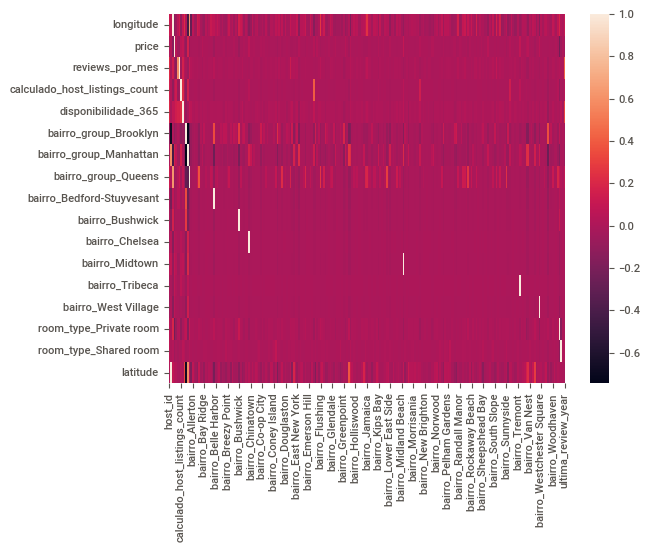

In [37]:
sns.heatmap(precificacao_correlacoes_filtradas)

Talvez devemos considerar todas as correlações independetes de serem fracas, já que nesse caso, algumas colunas CATEGORICAS SERIAM PERDIDAS. bairro_group_Manhattan e room_type_Private room possuem as maiores correlações. O que faz sentido, alugar um flat sai mais barato, por isso sua correlação é negativa e o bairro_group_Manhattan deve ser um lugar caro para se morar, por isso sua correlação é positiva

## SEPARAÇÃO TESTE X TREINO

Para esse estudo usaremos a biblioteca sklearn

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
precificacao_colunas_alta_correlacao_treino_teste = precificacao_colunas_alta_correlacao[:data_set_original_linhas]
input_json = precificacao_colunas_alta_correlacao[data_set_original_linhas:]

In [40]:
X = precificacao_colunas_alta_correlacao_treino_teste.drop(columns=["price"])
y = precificacao_colunas_alta_correlacao_treino_teste["price"]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=199, train_size=0.7)

In [42]:
print(f"tamanho treinamento: {len(X_train)}")
print(f"Tamanho teste: {len(X_test)}")


tamanho treinamento: 34225
Tamanho teste: 14669


## APRENDIZADO DO MODELO

In [43]:

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.ensemble import HistGradientBoostingRegressor

Usar o modelo de decision tree, por ser um modelos simples e pelo dataset possuir muitos campos boleanos

In [44]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34225 entries, 8023 to 28068
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   longitude                      34225 non-null  float64
 1   reviews_por_mes                34225 non-null  float64
 2   calculado_host_listings_count  34225 non-null  int64  
 3   disponibilidade_365            34225 non-null  int64  
 4   bairro_group_Brooklyn          34225 non-null  bool   
 5   bairro_group_Manhattan         34225 non-null  bool   
 6   bairro_group_Queens            34225 non-null  bool   
 7   bairro_Bedford-Stuyvesant      34225 non-null  bool   
 8   bairro_Bushwick                34225 non-null  bool   
 9   bairro_Chelsea                 34225 non-null  bool   
 10  bairro_Midtown                 34225 non-null  bool   
 11  bairro_Tribeca                 34225 non-null  bool   
 12  bairro_West Village            34225 non-null  b

In [45]:

gbc = HistGradientBoostingRegressor()
reg_tree = tree.DecisionTreeRegressor()
reg_forest = RandomForestRegressor(random_state=199)
svm_reg = svm.SVR()
svm_reg.fit(X_train, y_train)
reg_tree.fit(X_train, y_train)
reg_forest.fit(X_train, y_train)
gbc.fit(X_train, y_train)

HistGradientBoostingRegressor()

In [46]:
price_predicted_svm_reg = svm_reg.predict(X_test)
price_predicted_tree = reg_tree.predict(X_test)
price_predicted_reg_forest = reg_forest.predict(X_test)
price_predicted_gbc = gbc.predict(X_test)


In [47]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error


In [48]:
print("GBC")
print(f"MAE: {mean_absolute_error(y_test, price_predicted_gbc)}")
print(f"MSE: {mean_squared_error(y_test, price_predicted_gbc)}")
print(f"R2: {r2_score(y_test, price_predicted_gbc)}")

print("svm reg")
print(f"MAE: {mean_absolute_error(y_test, price_predicted_svm_reg)}")
print(f"MSE: {mean_squared_error(y_test, price_predicted_svm_reg)}")
print(f"R2: {r2_score(y_test, price_predicted_svm_reg)}")

print("TREE")
print(f"MAE: {mean_absolute_error(y_test, price_predicted_tree)}")
print(f"MSE: {mean_squared_error(y_test, price_predicted_tree)}")
print(f"R2: {r2_score(y_test, price_predicted_tree)}")

print("Regressor_Forest")
print(f"MAE: {mean_absolute_error(y_test, price_predicted_reg_forest)}")
print(f"MSE: {mean_squared_error(y_test, price_predicted_reg_forest)}")
print(f"R2: {r2_score(y_test, price_predicted_reg_forest)}")



GBC
MAE: 65.73796543691722
MSE: 44330.132171049576
R2: 0.1731166335125972
svm reg
MAE: 79.56107162106171
MSE: 55106.945708810505
R2: -0.027901667622321158
TREE
MAE: 92.77708091894472
MSE: 130736.34228645443
R2: -1.4386055609974355
Regressor_Forest
MAE: 68.36774941648893
MSE: 48521.42546049467
R2: 0.09493706274705482


*3.Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?*

Como foi visto é necessário a limpeza e tratamento dos dados, a escolha das variáveis se deu pela correlação com o atributo "target", algumas transformações foram realizadas como a dummificação de colunas, a categorização de colunas... Estamos resolvendo um problema de regressão já que a variável alvo não é categorica. Infelizmente nenhum modelo chegou com métricas boas para se prever com uma certa certeza o valor, O GBC tem ganhado bastante espaço e vejo alguns artigos falando bem dele que ele vem crescendo bem nos últimos anos. A métrica para esse tipo de análise seria a R2 junto com a MAE (mean absolute error), a R2 para checar a "acurácia" e a MAE para saber +- o erro da predição, como se fosse um desvio padrão.

## DADOS PARA SEREM VALIDADOS

In [49]:
input_json

,longitude,price,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,bairro_group_Brooklyn,bairro_group_Manhattan,bairro_group_Queens,bairro_Bedford-Stuyvesant,bairro_Bushwick,bairro_Chelsea,bairro_Midtown,bairro_Tribeca,bairro_West Village,room_type_Private room,room_type_Shared room,latitude
0,-73.98377,225,0.38,2,355,False,True,False,False,False,False,True,False,False,False,False,40.75362


*4.Supondo um apartamento com as seguintes características:*

In [50]:
price_predicted_gbc = gbc.predict(input_json.drop(columns=["price"]))
price_predicted_svm_reg = svm_reg.predict(input_json.drop(columns=["price"]))
price_predicted_tree = reg_tree.predict(input_json.drop(columns=["price"]))
price_predicted_forest = reg_forest.predict(input_json.drop(columns=["price"]))


print(f"gbc: {price_predicted_gbc}")
print(f"svm_reg: {price_predicted_svm_reg}")
print(f"tree: {price_predicted_tree}")
print(f"random_forest: {price_predicted_forest}")

gbc: [603.514283]
svm_reg: [106.2386133]
tree: [225.]
random_forest: [395.94]


Exportando os modelos

In [51]:
import pickle
modelos = [price_predicted_gbc, price_predicted_svm_reg, price_predicted_tree, price_predicted_forest]
nomes_modelo = ["HistGradientBoostingRegressor","DecisionTreeRegressor","RandomForestRegressor","SVR"]
for i in range(0,4):
    with open(f"{nomes_modelo[i]}.pkl", 'wb') as file:
        pickle.dump(modelos[i],file)

Conclusão: Talvez os atributos sejam bastante aleatórios a ponto do modelo não conseguir informações importantes para checar em uma conclusão, como visto anteriormente, as maiores correlações foram bairro_group_Manhattan == 0.163981,room_type_Private room == -0.240252, o que são números bem pequenos, tendo que correlações altas são 1 ou -1 e baixas estão perto de 0. Levantando a hipótese aqui que o DecisionTreeRegressor resultou em um modelo com overfiting, já que ele cravou o valor exato do preço.